CNN model trained on 3 second MFCC only feature set 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:
DATA_PATH ='/content/drive/My Drive/RP/newdata_10.json'

In [ ]:
def load_data(data_path):


    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    z = np.array(data['mapping'])
    return X, y, z


In [ ]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [ ]:
def prepare_datasets(test_size):

    # load data
    X, y, z = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_test, y_train,y_test, z


In [ ]:
def build_model(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32 , (3,3) ,activation = 'relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3,3),strides=(2,2),padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(64 , (3,3) ,activation = 'relu'))
    model.add(keras.layers.MaxPooling2D((3,3),strides=(2,2),padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(64 , (2,2) ,activation = 'relu'))
    model.add(keras.layers.MaxPooling2D((2,2),strides=(2,2),padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64,activation = 'relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(10,activation='softmax'))
    
    return model

In [ ]:
def predict(model, X, y):
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)
    # perform prediction
    prediction = model.predict(X)
    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)
    # get mappings for target and predicted label
    target = z[y]
    predicted = z[predicted_index]
    print("Target: {}, Predicted label: {}".format(target, predicted))

In [ ]:
# get train, test splits
X_train,X_test, y_train, y_test, z = prepare_datasets(0.2)


In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)


In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 64)         18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 64)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 64)         256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 64)         1

In [ ]:
#from keras.callbacks import EarlyStopping
#early_stopping_monitor = EarlyStopping(patience=3)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 8e-1:
            self.model.stop_training = True
callback = CustomCallback()

In [ ]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50,callbacks=[callback])

Epoch 1/50
250/250 [==============================] - 21s 79ms/step - loss: 2.5186 - accuracy: 0.2187 - val_loss: 1.6313 - val_accuracy: 0.4395
Epoch 2/50
250/250 [==============================] - 19s 77ms/step - loss: 1.6664 - accuracy: 0.4260 - val_loss: 1.3354 - val_accuracy: 0.5425
Epoch 3/50
250/250 [==============================] - 19s 77ms/step - loss: 1.4345 - accuracy: 0.4965 - val_loss: 1.2213 - val_accuracy: 0.5800
Epoch 4/50
250/250 [==============================] - 20s 78ms/step - loss: 1.2925 - accuracy: 0.5500 - val_loss: 1.1308 - val_accuracy: 0.5930
Epoch 5/50
250/250 [==============================] - 19s 77ms/step - loss: 1.1848 - accuracy: 0.5796 - val_loss: 1.0477 - val_accuracy: 0.6325
Epoch 6/50
250/250 [==============================] - 19s 77ms/step - loss: 1.1054 - accuracy: 0.6140 - val_loss: 1.0143 - val_accuracy: 0.6440
Epoch 7/50
250/250 [==============================] - 19s 77ms/step - loss: 1.0427 - accuracy: 0.6389 - val_loss: 0.9514 - val_accuracy:

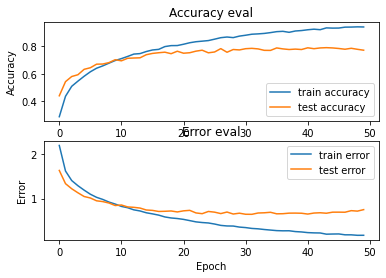

In [ ]:
# plot accuracy/error for training and validation
plot_history(history)

In [ ]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

63/63 - 1s - loss: 0.7537 - accuracy: 0.7720

Test accuracy: 0.7720000147819519


In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]


# predict sample
prediction = predict(model, X_to_predict, y_to_predict)


Target: classical, Predicted label: ['classical']


Confusion matrix, without normalization


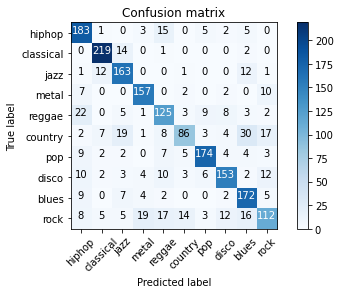

In [ ]:
#confusion matrix
import itertools
from itertools import cycle

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



preds = np.argmax(model.predict(X_test), axis = 1)
#y_orig = np.argmax(y_test, axis = 1)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,preds)

plot_confusion_matrix(cm,classes=z)
                     